## Load and Combine Data

In [143]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice

from datetime import datetime

import uncertainties as un
import uncertainties.unumpy as unp
nom = unp.nominal_values
err = unp.std_devs

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['figure.dpi'] = 150
%matplotlib inline

from li_funks.phreeqc import input_str_flex, run_phreeqc
import cbsyst as cb

from li_funks.plot import savefig

In [144]:
df = pd.read_csv('data/raw_conditions.csv', header=[0,1]).dropna(how='all').set_index(('labels', 'Chem_ID'))  # load master database
nd = pd.read_csv('data/processed_Neptune.csv', header=[0,1], index_col=0)  # load processed neptune data

df = df.join(nd).sort_index(1)  # merge into maset database
df.index.name = 'Sample'

/tmp/ipykernel_159423/3322531345.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.join(nd).sort_index(1)  # merge into maset database


In [145]:
# Calculate fluid M/Ca ratios
df.loc[:, ('solution', 'pre_LiCa')] = df.loc[:, ('solution', 'pre_Li')] / df.loc[:, ('solution', 'pre_Ca')]
df.loc[:, ('solution', 'pre_NaCa')] = df.loc[:, ('solution', 'pre_Na')] / df.loc[:, ('solution', 'pre_Ca')]

df.loc[:, ('solution', 'LiCa')] = df.loc[:, ('solution', 'Li')] / df.loc[:, ('solution', 'Ca')]
df.loc[:, ('solution', 'NaCa')] = df.loc[:, ('solution', 'Na')] / df.loc[:, ('solution', 'Ca')]

## Define Global Variables

In [146]:

R_LSVEC = 12.33  # 7Li/6Li of LSVEC standard 
R_PDB = 0.01118  # 13C/12C of PDB standard

LICA_UNCERTAINTY_FRACTION = 0.03  # Li/Ca measurements have ~5% precision

phreeqc_databases = ['pitzer', 'minteq.v4', 'pitzer_Li', 'minteq.v4_Li', 'llnl']  # databases to use for solution calculation

use_dbase = 'pitzer_Li'  # database to use for plotting/analysis

### Package Uncertainties for Propagation

In [147]:
for (label, var), _ in df.groupby(level=[0,1], axis=1):
    if '_std' in var:
        valuecolumn = var.replace('_std', '')
        ucolumn = 'u_' + valuecolumn
                
        df.loc[:, (label, ucolumn)] = unp.uarray(df.loc[:, (label, valuecolumn)], df.loc[:, (label, var)])

/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


### Fill missing solution values

In [148]:
# calculate pre- and post- experiment alpha7Li means for both LiCl batches
LiCl_batch1 = df.labels.LiCl_batch == 1
LiCl_batch2 = df.labels.LiCl_batch == 2

# isotopes
iso_LiCl_batch1_pre = un.ufloat(np.nanmean(df.loc[LiCl_batch1, ('Li_isotopes_alpha_LSVEC', 'fluid_pre')]),
                                np.nanstd(df.loc[LiCl_batch1, ('Li_isotopes_alpha_LSVEC', 'fluid_pre')]))
iso_LiCl_batch1_post = un.ufloat(np.nanmean(df.loc[LiCl_batch1, ('Li_isotopes_alpha_LSVEC', 'fluid_post')]),
                                 np.nanstd(df.loc[LiCl_batch1, ('Li_isotopes_alpha_LSVEC', 'fluid_post')]))
iso_LiCl_batch2_pre = un.ufloat(np.nanmean(df.loc[LiCl_batch2, ('Li_isotopes_alpha_LSVEC', 'fluid_pre')]),
                                np.nanstd(df.loc[LiCl_batch2, ('Li_isotopes_alpha_LSVEC', 'fluid_pre')]))
iso_LiCl_batch2_post = un.ufloat(np.nanmean(df.loc[LiCl_batch2, ('Li_isotopes_alpha_LSVEC', 'fluid_post')]),
                                 np.nanstd(df.loc[LiCl_batch2, ('Li_isotopes_alpha_LSVEC', 'fluid_post')]))

# Li/Ca
# conc_LiCl_batch1_pre = un.ufloat(np.nanmean(df.loc[LiCl_batch1, ('Fluid_Pre', 'Li_Ca')]),
#                                  np.nanstd(df.loc[LiCl_batch1, ('Li_Ca', 'fluid_pre')]))
# conc_LiCl_batch1_post = un.ufloat(np.nanmean(df.loc[LiCl_batch1, ('Li_Ca', 'fluid_post')]),
#                                   np.nanstd(df.loc[LiCl_batch1, ('Li_Ca', 'fluid_post')]))
# conc_LiCl_batch2_pre = un.ufloat(np.nanmean(df.loc[LiCl_batch2, ('Li_Ca', 'fluid_pre')]),
#                                  np.nanstd(df.loc[LiCl_batch2, ('Li_Ca', 'fluid_pre')]))
# conc_LiCl_batch2_post = un.ufloat(np.nanmean(df.loc[LiCl_batch2, ('Li_Ca', 'fluid_post')]),
#                                   np.nanstd(df.loc[LiCl_batch2, ('Li_Ca', 'fluid_post')]))

In [149]:
for g, d in df.groupby(('labels', 'Experiment')):
    ind_first = d.index[0]
    # isotopes
    if all(d.Li_isotopes_alpha_LSVEC.fluid_pre.isnull()):
        batch = d.loc[ind_first, ('labels', 'LiCl_batch')]
        if np.isnan(batch):
            continue
        print('Using alpha7Li mean of LiCl batch {:.0f} for {}'.format(batch, ind_first))
        if batch == 1:
            df.loc[d.index, ('Li_isotopes_alpha_LSVEC', 'u_fluid_pre')] = iso_LiCl_batch1_pre
            df.loc[d.index, ('Li_isotopes_alpha_LSVEC', 'u_fluid_post')] = iso_LiCl_batch1_post
        elif batch == 2:
            df.loc[d.index, ('Li_isotopes_alpha_LSVEC', 'u_fluid_pre')] = iso_LiCl_batch2_pre
            df.loc[d.index, ('Li_isotopes_alpha_LSVEC', 'u_fluid_post')] = iso_LiCl_batch2_post
    else:
        df.loc[d.index, ('Li_isotopes_alpha_LSVEC', 'u_fluid_pre')] = df.loc[ind_first, ('Li_isotopes_alpha_LSVEC', 'u_fluid_pre')]
        df.loc[d.index, ('Li_isotopes_alpha_LSVEC', 'u_fluid_post')] = df.loc[ind_first, ('Li_isotopes_alpha_LSVEC', 'u_fluid_post')]
    
    # Li/Ca
#     if all(d.Li_Ca.fluid_pre.isnull()):
#         batch = d.loc[ind_first, ('Labels', 'LiCl_batch')]
#         if np.isnan(batch):
#             continue
#         print('Using Li/Ca mean of LiCl batch {:.0f} for {}'.format(batch, ind_first))
#         if batch == 1:
#             df.loc[d.index, ('Li_Ca', 'u_fluid_pre')] = conc_LiCl_batch1_pre
#             df.loc[d.index, ('Li_Ca', 'u_fluid_post')] = conc_LiCl_batch1_post
#         elif batch == 2:
#             df.loc[d.index, ('Li_Ca', 'u_fluid_pre')] = conc_LiCl_batch2_pre
#             df.loc[d.index, ('Li_Ca', 'u_fluid_post')] = conc_LiCl_batch2_post
#     else:
    df.loc[d.index, ('solution', 'u_pre_LiCa')] = unp.uarray(df.loc[ind_first, ('solution', 'pre_LiCa')], df.loc[ind_first, ('solution', 'pre_LiCa')] * LICA_UNCERTAINTY_FRACTION)
    df.loc[d.index, ('solution', 'u_LiCa')] = unp.uarray(df.loc[ind_first, ('solution', 'LiCa')], df.loc[ind_first, ('solution', 'LiCa')] * LICA_UNCERTAINTY_FRACTION)

Using alpha7Li mean of LiCl batch 1 for B1


In [150]:
df.loc[d.index, ('solution', 'u_pre_LiCa')] = unp.uarray(df.loc[ind_first, ('solution', 'pre_LiCa')], df.loc[ind_first, ('solution', 'pre_LiCa')] * LICA_UNCERTAINTY_FRACTION)

## Mass Balance Calculations

See `S0_13C_Fractionation` notebook for explanation.

In [151]:
from li_funks.carbon_isotopes import alpha_BC, alpha_SB
from li_funks.isotope_notation import R_2_A, A_2_R, alpha_2_A, A_2_alpha

In [152]:
df.loc[:, ('isotopes', 'alpha_PDB')] = 1 + df.loc[:, ('isotopes', 'd13C_PDB')] / 1000

In [153]:
Apr18QP = df.loc[df.index.str.contains('Apr'), ('isotopes', 'alpha_PDB')]
Jun18QP = df.loc[df.index.str.contains('Jun'), ('isotopes', 'alpha_PDB')]

a_Apr18QP = un.ufloat(Apr18QP.mean(), Apr18QP.std())
a_Jun18QP = un.ufloat(Jun18QP.mean(), Jun18QP.std())

df.loc[df.labels.BaCO3_batch == 'Apr18QP', ('MassBalance', 'og_alpha')] = a_Apr18QP * alpha_BC(df.loc[df.labels.BaCO3_batch == 'Apr18QP', ('solution', 'TempC')]) * alpha_SB()
df.loc[df.labels.BaCO3_batch == 'June18QP', ('MassBalance', 'og_alpha')] = a_Apr18QP * alpha_BC(df.loc[df.labels.BaCO3_batch == 'June18QP', ('solution', 'TempC')]) * alpha_SB()

In [154]:
seeds = df.loc[df.labels.Experiment == 'Calcite_Seeds', ('isotopes', 'alpha_PDB')]
a_seeds = un.ufloat(seeds.mean(), seeds.std())

df.loc[:, ('MassBalance', 'seed_alpha')] = a_seeds

In [155]:
df.loc[:, ('MassBalance', 'seed_A')] = alpha_2_A(df.loc[:, ('MassBalance', 'seed_alpha')], R_PDB)
df.loc[:, ('MassBalance', 'og_A')] = alpha_2_A(df.loc[:, ('MassBalance', 'og_alpha')], R_PDB)
df.loc[:, ('MassBalance', 'sample_A')] = alpha_2_A(df.loc[:, ('isotopes', 'alpha_PDB')], R_PDB)

$A_{sample}$ can be expressed as a linear mixture of $A_{OG}$ and $A_{seed}$:
$$
A_{sample} = f_{OG} A_{OG} + (1-f_{OG}) A_{seed}
$$
Which gives:
$$
f_{OG} = \frac{A_{sample} - A_{seed}}{A_{OG} - A_{seed}}
$$

In [156]:
df.loc[:, ('MassBalance', 'f_og')] = ((df.loc[:, ('MassBalance', 'sample_A')] - df.loc[:, ('MassBalance', 'seed_A')]) / 
                                      (df.loc[:, ('MassBalance', 'og_A')] - df.loc[:, ('MassBalance', 'seed_A')]))

# also calculate this based on the initial and final masses
df.loc[:, ('mass', 'f_og')] = (df.loc[:, ('mass', 'Final_mg')] - df.loc[:, ('mass', 'Initial_mg')]) / df.loc[:, ('mass', 'Final_mg')]

Text(0, 0.5, '$^{13}C$-derived f_og')

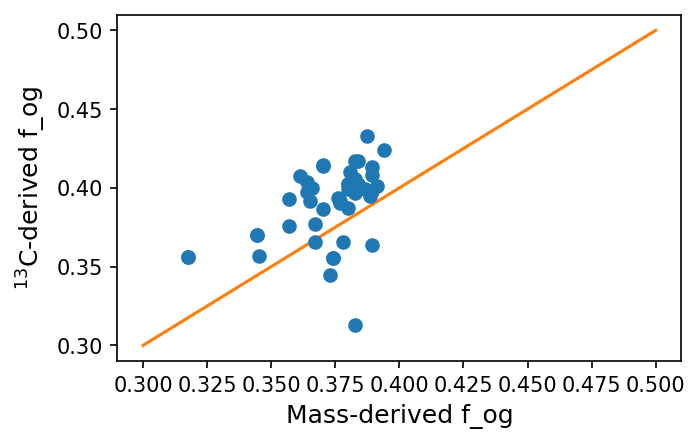

In [157]:
plt.errorbar(df.loc[:, ('mass', 'f_og')], unp.nominal_values(df.loc[:, ('MassBalance', 'f_og')]),
             yerr=unp.std_devs(df.loc[:, ('MassBalance', 'f_og')]), lw=0, elinewidth=1, marker='o')
plt.plot([.3, .5], [.3, .5])
plt.xlabel('Mass-derived f_og')
plt.ylabel('$^{13}C$-derived f_og')

## Precipitation Rate Calculation

Precipitation rate $R$ ($mol\ m^{-2}\ s^{-1}$) is estimated from the start and end volume of the calcite particles and experimental time, assuming cubic geometry. A cube whose volume $V$ changes at a fixed rate $R_v$ proportional to its surface area $A$ is described by:
$$
\frac{dV}{dt} = R_v\ A = R\ 6 V^{2/3}
$$
This is separable to:
$$
\frac{1}{6 V^{2/3}} dV = R_v\ dt
$$
which can be solved by integrating both sides:
$$
\begin{align}
\int{\frac{1}{6 V^{2/3}} dV} &= \int{R_v\ dt} \\
\frac{V^{1/3}}{2} + C &= R_v t + C \\
V^{1/3} &= 2 R_v t + C \\
V &= (2 R_v t + C)^3
\end{align}
$$
and
$$
R_v = \frac{V^{1/3} - C}{2t}
$$
We know that when $t = 0$, $V = V_0$, so:
$$
\begin{align}
V_0 &= C^3 \\
C &= V_0^{1/3}
\end{align}
$$
so:
$$
R_v = \frac{V^{1/3} - V_0^{1/3}}{2t}
$$
Which is in units of $\frac{V}{A t}$. This can be converted to our target units ($mol\ m^{-2}\ s^{-1}$) using the density ($\rho$) and molecular weight ($M_{CaCO_3}$) of CaCO<sub>3</sub>:
$$
R = \frac{R_v \rho}{M_{CaCO_3}}
$$

In [158]:
# Constants
CALCITE_MW = 100.09
CALCITE_RHO = 2.7e6  # g/m3
SEED_SIZE = un.ufloat(10, 0.1) * 1e-6  # 10 um cube, with GUESSED UNCERTAINTY
SEED_SA = 6 * SEED_SIZE**2
SEED_VOL = SEED_SIZE**3

# Rate function
def calc_R(v0, v1, t):
    """
    Calculate R from initial and final volumes and elapsed time.
    
    Parameters
    ----------
    v0 : float or array-like
        The starting volume of the cube.
    v1 : float or array-like
        The final volume of the cube.
    t : float or array-like
        The elapsed time.
        
    Returns
    -------
    float or array-like : R in units of V / A / t, where t is in the same units as
        input t, and V and A are in the same units as v0.
    """
    return (v1**(1/3) - v0**(1/3)) / (2 * t)

In [159]:
## REPLICATING METHOD FROM JOJI's SPREADSHEET

# df.loc[:, ('R', 'n_seeds')] = df.loc[:, ('Mass', 'Initial_mg')] * 1e-3 / calcite_rho / seed_vol  # calculate number of starting seeds
# df.loc[:, ('R', 'total_seed_SA')] = df.loc[:, ('R', 'n_seeds')] * seed_SA  # calculate total seed area in m2

# df.loc[:, ('R', 'final_vol')] = df.loc[:, ('Mass', 'Final_mg')] * 1e-3 / calcite_rho / df.loc[:, ('R', 'n_seeds')]  # calculate final crystal vol in m3, assuming homogeneous growth
# df.loc[:, ('R', 'final_SA')] = 6 * df.loc[:, ('R', 'final_vol')]**(2/3)  # calculate final surface area per crystal in m2
# df.loc[:, ('R', 'total_final_SA')] = df.loc[:, ('R', 'final_SA')] * df.loc[:, ('R', 'n_seeds')]

# df.loc[:, ('R', 'og_13C_moles')] = df.loc[:, ('MassBalance', 'f_og')] * df.loc[:, ('Mass', 'Final_mg')] * 1e-3 / calcite_mw  # calculate moles of overgrowth using 13C mass balance
# df.loc[:, ('R', 'og_mass_moles')] = df.loc[:, ('Mass', 'f_og')] * df.loc[:, ('Mass', 'Final_mg')] * 1e-3 / calcite_mw  # calculate moles of overgrowth using final and initial mass

# df.loc[:, ('R', 'og_moles')] = unp.uarray(unp.nominal_values(df.loc[:, [('R', 'og_13C_moles'), ('R', 'og_mass_moles')]]).mean(axis=1), 
#                                           unp.nominal_values(df.loc[:, [('R', 'og_13C_moles'), ('R', 'og_mass_moles')]]).std(axis=1))  # use mean and std of both

# df.loc[:, ('R', 'R_final')] = df.loc[:, ('R', 'og_moles')] / df.loc[:, ('R', 'total_final_SA')] / df.loc[:, ('Conditions', 'Exp_Duration_s')]
# df.loc[:, ('R', 'R')] = df.loc[:, ('R', 'og_moles')] / df.loc[:, ('R', 'total_seed_SA')] / df.loc[:, ('Conditions', 'Exp_Duration_s')]
# df.loc[:, ('R', 'log10R')] = unp.log10(df.loc[:, ('R', 'R')])

In [160]:
seed_total_mass = df.loc[:, ('mass', 'Initial_mg')] * 1e-3  # grams
final_total_mass = df.loc[:, ('mass', 'Final_mg')] * 1e-3  # grams

# calculate n seeds and initial seed volume
df.loc[:, ('R', 'n_seeds')] = seed_total_mass / CALCITE_RHO / SEED_VOL
df.loc[:, ('R', 'seed_vol')] = SEED_VOL  # m3 / seed

# calculate final total mass using 13C-derived f_og
final_total_mass_13C = seed_total_mass / (1 - df.loc[:, ('MassBalance', 'f_og')])  # g
# calculate the final volume of each crystal after precipitation
df.loc[:, ('R', 'final_vol_13C')] = final_total_mass_13C / CALCITE_RHO / df.loc[:, ('R', 'n_seeds')]  # m3 / seed

In [161]:
# calculate precipitation rate
df.loc[:, ('R', 'R_13C')] = calc_R(df.loc[:, ('R', 'seed_vol')], df.loc[:, ('R', 'final_vol_13C')], df.loc[:, ('solution', 'Exp_Duration_s')]) * CALCITE_RHO / CALCITE_MW
df.loc[:, ('R', 'log10R_13C')] = unp.log10(df.loc[:, ('R', 'R_13C')])

## Mass-Balance Composition Correction

The measured composition $C_{meas}$ of the final precipitates is a mixture of compositions of the calcite seed ($C_{seed}$) and the precipitated overgrowth ($C_{OG}$), following:
$$
C_{meas} = f_{OG} C_{OG} + (1 - f_{OG}) C_{seed}
$$
Thus, $C_{OG}$ can be calculated as:
$$
C_{OG} = \frac{C_{meas} - (1 - f_{OG}) C_{seed}}{f_{OG}}
$$
Where, to avoid non-linear mixing behaviour of ratios, C is always in units of fractional abundance ($A$).

### Li/Ca

In [162]:
def calc_Cog(Cmeas, Cseed, fOG):
    return (Cmeas - (1 - fOG) * Cseed) / fOG

In [163]:
# Seed Li/Ca
RAW_SEED_LICA = np.array([0.72272, 0.88831]) * 1e-6  # mol/mol
# THIS NEEDS CONFIRMING

# Calculate seed value
seed_LiCa = un.ufloat(RAW_SEED_LICA.mean(), RAW_SEED_LICA.std())
seed_ALi = R_2_A(seed_LiCa)

# Li/Ca Uncertainty
df.loc[:, ('solid', 'u_LiCa')] = unp.uarray(df.loc[:, ('solid', 'LiCa')], df.loc[:, ('solid', 'LiCa')] * LICA_UNCERTAINTY_FRACTION)

/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [164]:
df.loc[:, ('OG', 'LiCa')] = A_2_R(calc_Cog(R_2_A(df.loc[:, ('solid', 'u_LiCa')]), seed_ALi, df.loc[:, ('MassBalance', 'f_og')]))
df.loc[:, ('OG', 'DLi')] = df.loc[:, ('OG', 'LiCa')] / df.loc[:, ('solution', 'u_LiCa')]

### Li Isotopes
For isotopes, the mixture depends on the *amount of Li* in each component:
$$
^7A_{meas}\ ^{Li}A_{meas} = ^7A_{OG}\ ^{Li}A_{OG}\ f_{OG} +\ ^7A_{seed}\ ^{Li}A_{seed}\ (1 - f_{OG})
$$
where $^7A$ is the fractional abundance of $^7Li$ as a proportional of total Li, and $^{Li}A$ is the fractional abundance of total Li in the solid. From this,
$$
^7A_{OG} = \frac{^7A_{meas}\ ^{Li}A_{meas} -\ ^7A_{seed}\ ^{Li}A_{seed}\ (1 - f_{OG})}{^{Li}A_{OG}\ f_{OG}}
$$

In [227]:
A7_meas = alpha_2_A(df.loc[:, ('Li_isotopes_alpha_LSVEC', 'u_solid')], R_LSVEC)
#########################################################################################
# THIS NEEDS CHECKING!!
A7_seed = R_2_A(R_LSVEC)  # assuming seeds are identical to LSVEC (i.e. delta close to 0)
#########################################################################################

f_Li_meas = R_2_A(df.loc[:, ('solid', 'u_LiCa')])
f_Li_seed = seed_ALi * (1 - df.loc[:, ('MassBalance', 'f_og')])
f_Li_og = R_2_A(df.loc[:, ('OG', 'LiCa')]) * df.loc[:, ('MassBalance', 'f_og')]

df.loc[:, ('Li_isotopes_alpha_LSVEC', 'OG')] = A_2_alpha((A7_meas * f_Li_meas - A7_seed * f_Li_seed) / f_Li_og, R_LSVEC)

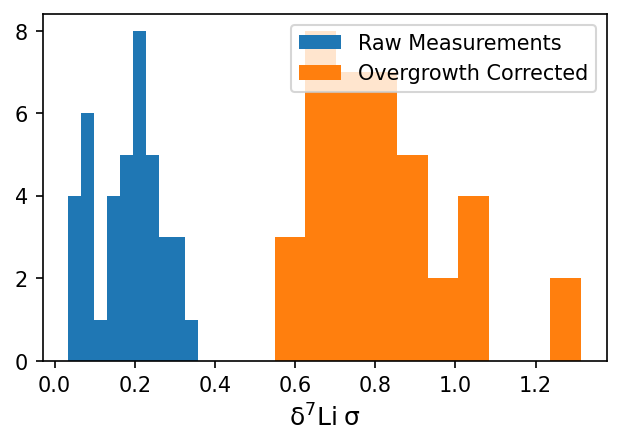

In [228]:
# plot of uncertainty on isotope measurements
plt.hist(df.Li_isotopes_alpha_LSVEC.solid_std * 1e3, label='Raw Measurements')
plt.hist(err(df.Li_isotopes_alpha_LSVEC.OG) * 1e3, label='Overgrowth Corrected')
plt.xlabel('$\delta^7Li~\sigma$ ')
plt.legend()

In [229]:
df.Li_isotopes_alpha_LSVEC.head()

,fluid_post,fluid_post_std,fluid_pre,fluid_pre_std,solid,solid_std,u_fluid_post,u_fluid_pre,u_solid,OG
Sample,,,,,,,,,,
1.1,0.330462,0.000066,0.330429,0.000064,0.339371,0.000105,0.33046+/-0.00007,0.33043+/-0.00006,0.33937+/-0.00011,0.3302+/-0.0010
1.2,NaN,NaN,NaN,NaN,0.342588,0.000132,0.33046+/-0.00007,0.33043+/-0.00006,0.34259+/-0.00013,0.3330+/-0.0011
1.2b,NaN,NaN,NaN,NaN,0.339625,0.000058,0.33046+/-0.00007,0.33043+/-0.00006,0.33963+/-0.00006,0.3300+/-0.0010
1.3,NaN,NaN,NaN,NaN,0.338550,0.000242,0.33046+/-0.00007,0.33043+/-0.00006,0.33855+/-0.00024,0.3290+/-0.0011
2.1,0.330524,0.000046,0.330518,0.000047,0.335462,0.000066,0.33052+/-0.00005,0.33052+/-0.00005,0.33546+/-0.00007,0.3298+/-0.0006


### Calculate Fractionation vs Fluid

In [231]:
df.loc[:, ('Li_isotopes_vs_fluid', 'alpha_og')] = df.loc[:, ('Li_isotopes_alpha_LSVEC', 'OG')] / df.loc[:, ('Li_isotopes_alpha_LSVEC', 'u_fluid_pre')]
df.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')] = (df.loc[:, ('Li_isotopes_vs_fluid', 'alpha_og')] - 1) * 1000

# Make Error Contribution Plot

## Solution Composition

The total fluid volume of the precipitation is 1 L, which contains aliquots of three stock solution (NaHCO3, LiCl, CaCl2). The approximate concentrations of these stock solutions is:

| Stock | Molar |
|-------|-------|
| $CaCl_2$ | 0.95 |
| $LiCl$ | 0.1 |
| $NaHCO_3$ | 0.3 |
 
These concentrations have *not* been measured. They are calculated from the weights of reagents added to the stock solutions, hence approximate.

In [170]:
# df.loc[:, ('solution', cols)]

# cols = [c for c in df.solution.columns if 'pre' in c]
# df.loc[:, ('solution', cols)] = 

In [172]:
from otools.chemistry import decompose_molecule

In [173]:
TOTAL_VOL = 1000  # ml

# solution concentrations
MOLAR_CONCS = {
    'CaCl2': 0.9,  # M
    'LiCl': 0.1,  # M
#     'Na2CO3': 0.3  # M
    'NaHCO3': 0.3  # M
}

sols_added = [c for c in df.solution.columns if 'added_' in c]
els_of_interest = ['added_Na', 'added_Cl', 'added_C', 'added_Li', 'added_Ca']

for el in els_of_interest:
    df.loc[:, ('solution', el)] = 0

In [174]:
df.solution.columns

Index(['Ca', 'Exp_Duration_s', 'Li', 'Na', 'TempC', 'added_CaCl2',
       'added_LiCl', 'added_NaHCO3', 'f_DIC', 'pH', 'pH_std', 'pre_Ca',
       'pre_Li', 'pre_Na', 'pre_LiCa', 'pre_NaCa', 'LiCa', 'NaCa', 'u_pH',
       'u_pre_LiCa', 'u_LiCa', 'added_Na', 'added_Cl', 'added_C', 'added_Li',
       'added_Ca'],
      dtype='object')

In [175]:
for sol in sols_added:
    compound = sol.replace('added_', '')
    els = decompose_molecule(compound)
    
    for el, mult in els.items():
        adel = 'added_' + el
        if adel in df.solution.columns:
            df.loc[:, ('solution', adel)] += mult * df.loc[:, ('solution', sol)] * MOLAR_CONCS[compound] / TOTAL_VOL
            
df.loc[:, ('solution', 'added_LiCa')] = df.loc[:, ('solution', 'added_Li')] / df.loc[:, ('solution', 'added_Ca')]


Text(0, 0.5, 'Calculated Fluid Li/Ca\n(from stock additions)')

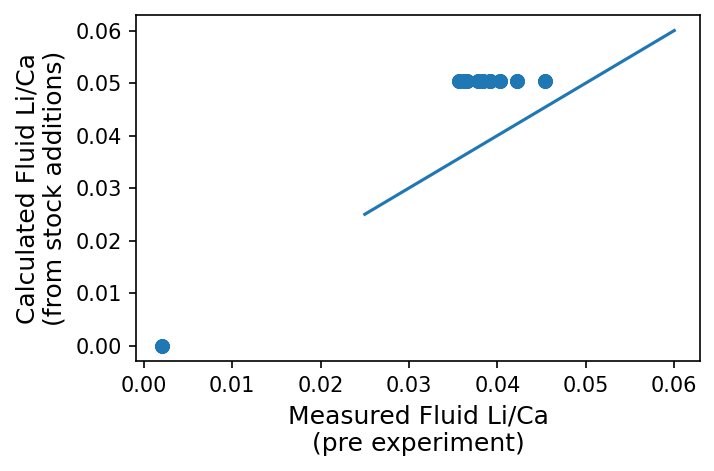

In [182]:
plt.scatter(nom(df.loc[:, ('solution', 'u_pre_LiCa')]), df.loc[:, ('solution', 'added_LiCa')])
plt.plot([.025, .06], [.025, .06])
plt.xlabel('Measured Fluid Li/Ca\n(pre experiment)')
plt.ylabel('Calculated Fluid Li/Ca\n(from stock additions)')

# plt.savefig('plots/SolutionComposition.pdf')

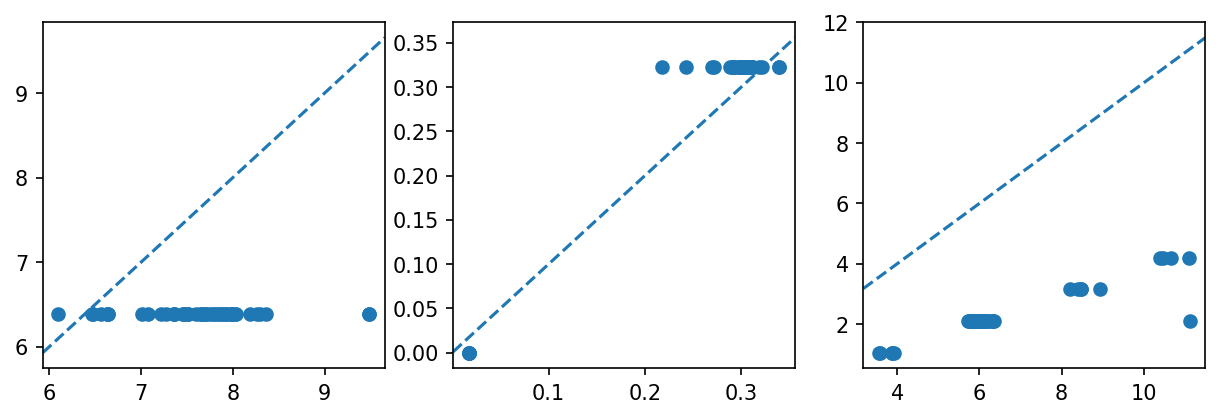

In [183]:
fig, axs = plt.subplots(1, 3, figsize=[10,3])

xca, xli, xna = axs

xca.scatter(df.loc[:, ('solution', 'Ca')] * 1e3, df.loc[:, ('solution', 'added_Ca')] * 1e3)
xli.scatter(df.loc[:, ('solution', 'Li')] * 1e3, df.loc[:, ('solution', 'added_Li')] * 1e3)
xna.scatter(df.loc[:, ('solution', 'Na')] * 1e3, df.loc[:, ('solution', 'added_Na')] * 1e3)

for ax in axs:
    xlim = ax.get_xlim()
    ax.set_xlim(xlim)
    ax.plot(xlim, xlim, ls='dashed', zorder = -2)
#     ax.plot(xlim, np.array(0.5) * xlim, ls='dashed', zorder = -2)

Measured Na is higher because Alkalinity and DIC are added as a Na salt.

## Calculate solution carbon chemistry using PHREEQC.

In [234]:
from li_funks.phreeqc import build_input_string, run_phreeqc

In [235]:
df.loc[:, ('solution_phreeq', 'Li')] = df.loc[:, ('solution', 'Li')]
df.loc[:, ('solution_phreeq', 'Ca')] = df.loc[:, ('solution', 'Ca')]
df.loc[:, ('solution_phreeq', 'Na')] = df.loc[:, ('solution', 'Na')]
df.loc[:, ('solution_phreeq', 'C')] = df.loc[:, ('solution', 'added_C')]
df.loc[:, ('solution_phreeq', 'Cl')] = df.loc[:, ('solution', 'added_Cl')]
df.loc[:, ('solution_phreeq', 'pH')] = df.loc[:, ('solution', 'pH')]
df.loc[:, ('solution_phreeq', 'temp')] = df.loc[:, ('solution', 'TempC')]

In [35]:
for db in phreeqc_databases:
    inputs = {}
    for i, row in df.iterrows():
        inputs[i] = build_input_string(row)

    solchem = pd.DataFrame.from_dict(run_phreeqc(inputs, db)).T
    solchem.columns = pd.MultiIndex.from_product([[db], solchem.columns])

    df = df.join(solchem)

## Trends in data

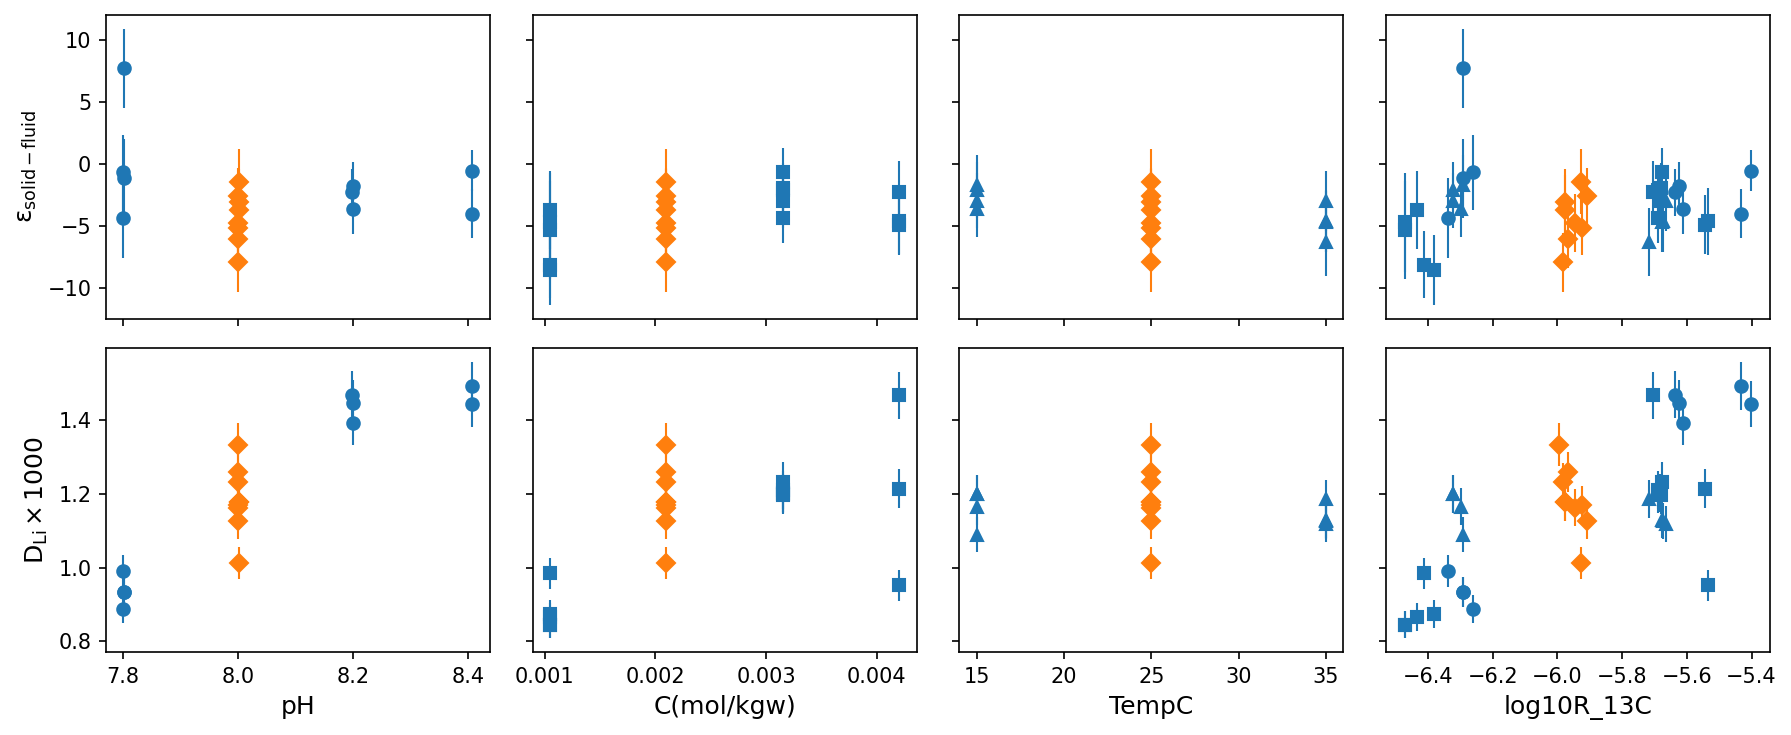

In [36]:
ind_ctrl = df.labels.Experiment.str.contains('Control')
ind_pH = df.labels.Experiment.str.contains('pH')
ind_DIC = df.labels.Experiment.str.contains('DIC')
ind_temp = df.labels.Experiment.str.contains('T =')
ind_R = ~ind_ctrl

fig, axs = plt.subplots(2, 4, figsize=[12, 5], sharex='col', sharey='row')

inds = [ind_pH, ind_DIC, ind_temp, ind_R]
markers = ['o', 's', '^', 'x']
xvars = [(use_dbase, 'pH'), (use_dbase, 'C(mol/kgw)'), ('solution', 'TempC'), ('R', 'log10R_13C')]
y_iso = ('Li_isotopes_vs_fluid', 'epsilon_og')
y_conc = ('OG', 'DLi')

for i, col in enumerate(axs.T):
    iax, cax = col
    xvar = xvars[i]
    ind = inds[i]
    m = markers[i]
    
    x = df.loc[ind, xvar]
    cx = df.loc[ind_ctrl, xvar]
    
    # plot control
    cx = df.loc[ind_ctrl, xvar]
    cyi = df.loc[ind_ctrl, y_iso]
    iax.errorbar(nom(cx), nom(cyi), yerr=err(cyi), xerr=err(cx), marker='D', lw=0, elinewidth=1, color='C1')
    cyc = df.loc[ind_ctrl, y_conc] * 1e3
    cax.errorbar(nom(cx), nom(cyc), yerr=err(cyc), xerr=err(cx), marker='D', lw=0, elinewidth=1, color='C1')
    
    
    # plot data
    if m != 'x':
        x = df.loc[ind, xvar]    
        yi = df.loc[ind, y_iso]
        iax.errorbar(nom(x), nom(yi), yerr=err(yi), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
        yc = df.loc[ind, y_conc] * 1e3
        cax.errorbar(nom(x), nom(yc), yerr=err(yc), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
    else:
        for j, ind in enumerate(inds[:-1]):
            m = markers[j]
            x = df.loc[ind, xvar]    
            yi = df.loc[ind, y_iso]
            iax.errorbar(nom(x), nom(yi), yerr=err(yi), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
            yc = df.loc[ind, y_conc] * 1e3
            cax.errorbar(nom(x), nom(yc), yerr=err(yc), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
    
    cax.set_xlabel(xvar[-1])
    if cax.get_subplotspec().is_first_col():
        cax.set_ylabel('$D_{Li} \\times 1000$')
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel('$\epsilon_{solid-fluid}$')
    
fig.tight_layout()
# fig.savefig('plots/experiment_overview_individual.pdf')

In [37]:
# remove crazy high d7Li

df = df.loc[df.loc[:, y_iso] < 0]

## Per-Experiment Averages

In [38]:
# combine controls
df.loc[df.labels.Experiment.str.contains('Control'), ('labels', 'Experiment')] = 'Control'

with open('data/processed_LiDataFull.csv', 'w') as f:
    f.write(datetime.now().strftime('# Exported on: %Y-%m-%d %H:%M:%S\n'))
    df.to_csv(f)
    
df.to_pickle('data/processed_LiDataFull.pkl')

In [39]:
def nompass(a):
    try:
        return nom(a)
    except ValueError:
        return a

# calculate per-group mean and standard deviations
mdf = df.apply(nompass).groupby(('labels', 'Experiment')).aggregate(['mean', 'std'])

# drop irrelevant columns
mdf.sort_index(1, inplace=True)
mdf.drop('labels', axis=1, inplace=True)
drop = []
for i, _ in mdf.groupby(level=[0,1], axis=1):
    if 'u_' in i[1] or '_std' in i[1]:
        drop.append(i)
mdf.drop(drop, axis=1, inplace=True)
# mdf.drop(['BaCO3', 'Calcite_Seeds'], axis=0, inplace=True)
mdf.index.name = 'Experiment'

# export
with open('data/processed_LiDataSummary.csv', 'w') as f:
    f.write(datetime.now().strftime('# Exported on: %Y-%m-%d %H:%M:%S\n'))
    mdf.to_csv(f)

# package means and standard deviations for 
u_mdf = pd.DataFrame(index=mdf.index, columns=mdf.columns.droplevel(-1).drop_duplicates())

for i, g in mdf.groupby(level=[0,1], axis=1):
    try:
        u_mdf.loc[:, i] = unp.uarray(g.loc[:, i]['mean'], g.loc[:, i]['std'])
    except:
        print(i, g)

u_mdf.to_pickle('data/processed_LiDataSummary.pkl')

/tmp/ipykernel_159423/1273078252.py:8: FutureWarning: [('Notes', 'solution'), ('labels', 'BaCO3_batch'), ('labels', 'Exp_Date'), ('labels', 'Type'), ('labels', 'isotope_LabID')] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mdf = df.apply(nompass).groupby(('labels', 'Experiment')).aggregate(['mean', 'std'])
/tmp/ipykernel_159423/1273078252.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  mdf.sort_index(1, inplace=True)
/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: inv

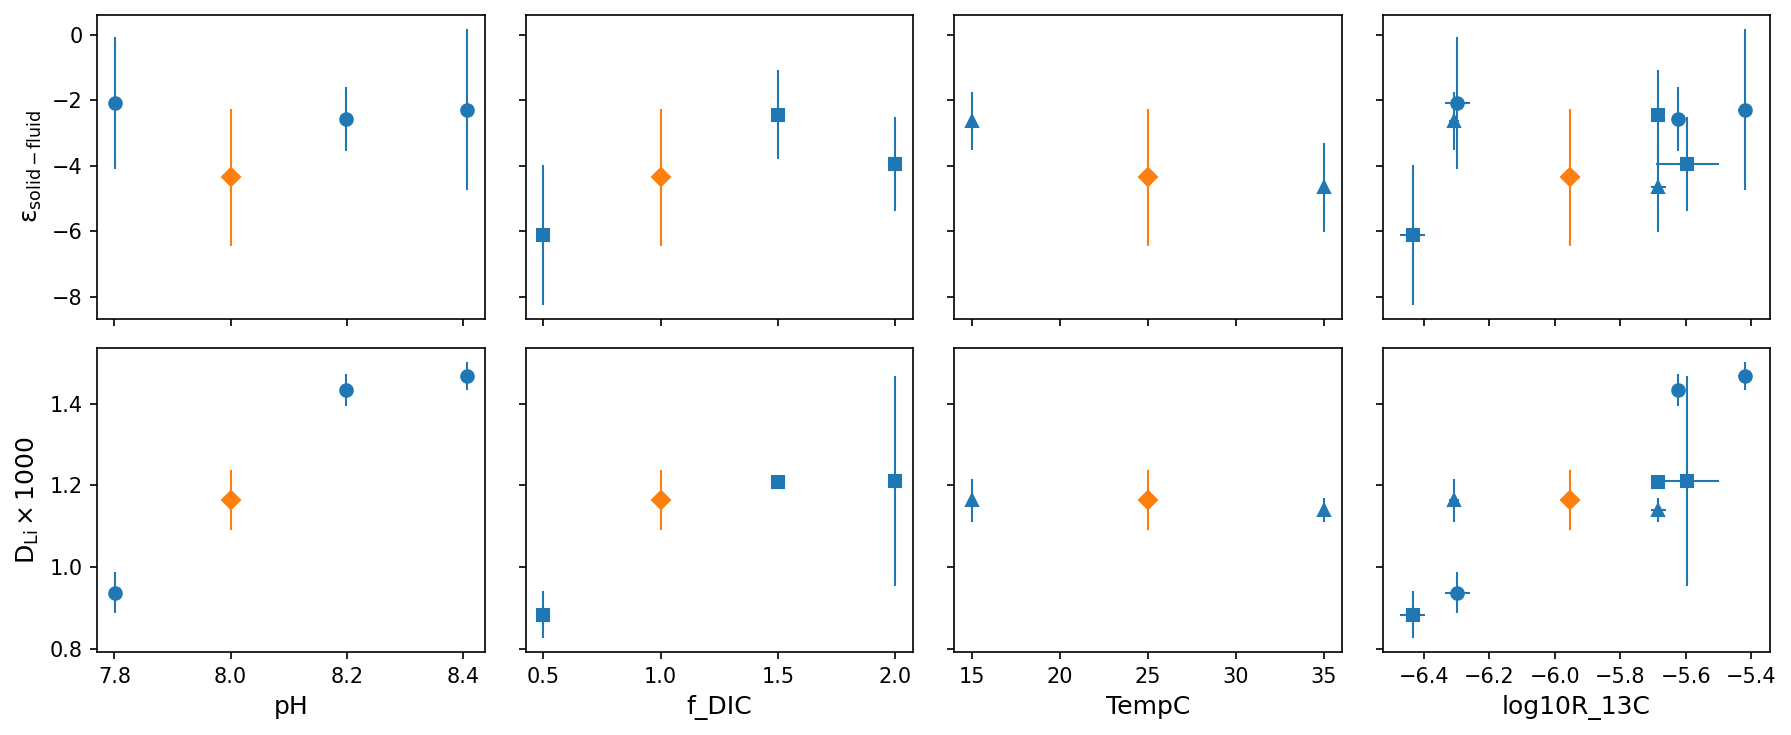

In [40]:
ind_ctrl = u_mdf.index.str.contains('Control')
ind_pH = u_mdf.index.str.contains('pH')
ind_DIC = u_mdf.index.str.contains('DIC')
ind_temp = u_mdf.index.str.contains('T =')
ind_R = ~ind_ctrl

fig, axs = plt.subplots(2, 4, figsize=[12, 5], sharex='col', sharey='row')

inds = [ind_pH, ind_DIC, ind_temp, ind_R]
markers = ['o', 's', '^', '']
xvars = [('solution', 'pH'), ('solution', 'f_DIC'), ('solution', 'TempC'), ('R', 'log10R_13C')]
y_iso = ('Li_isotopes_vs_fluid', 'epsilon_og')
y_conc = ('OG', 'DLi')

for i, col in enumerate(axs.T):
    iax, cax = col
    xvar = xvars[i]
    ind = inds[i]
    m = markers[i]
    
    # plot control
    cx = u_mdf.loc[ind_ctrl, xvar]
    cyi = u_mdf.loc[ind_ctrl, y_iso]
    iax.errorbar(nom(cx), nom(cyi), yerr=err(cyi), xerr=err(cx), marker='D', lw=0, elinewidth=1, color='C1')
    cyc = u_mdf.loc[ind_ctrl, y_conc] * 1e3
    cax.errorbar(nom(cx), nom(cyc), yerr=err(cyc), xerr=err(cx), marker='D', lw=0, elinewidth=1, color='C1')
    
    # plot data
    if m != '':
        x = u_mdf.loc[ind, xvar]    
        yi = u_mdf.loc[ind, y_iso]
        iax.errorbar(nom(x), nom(yi), yerr=err(yi), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
        yc = u_mdf.loc[ind, y_conc] * 1e3
        cax.errorbar(nom(x), nom(yc), yerr=err(yc), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
    else:
        for j, ind in enumerate(inds[:-1]):
            m = markers[j]
            x = u_mdf.loc[ind, xvar]    
            yi = u_mdf.loc[ind, y_iso]
            iax.errorbar(nom(x), nom(yi), yerr=err(yi), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
            yc = u_mdf.loc[ind, y_conc] * 1e3
            cax.errorbar(nom(x), nom(yc), yerr=err(yc), xerr=err(x), marker=m, lw=0, elinewidth=1, color='C0')
    
    cax.set_xlabel(xvar[-1])
    if cax.get_subplotspec().is_first_col():
        cax.set_ylabel('$D_{Li} \\times 1000$')
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel('$\epsilon_{solid-fluid}$')
    
fig.tight_layout()
# fig.savefig('plots/experiment_overview.pdf')

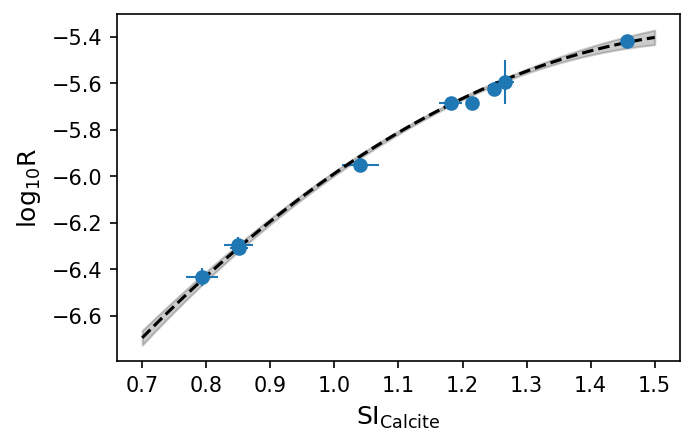

In [41]:
x = u_mdf.loc[:, (use_dbase, 'si_Calcite')]
y = u_mdf.loc[:, ('R', 'log10R_13C')]

plt.errorbar(nom(x), nom(y), xerr=err(x), yerr=err(y), marker='o', elinewidth=1, linewidth=0)
plt.xlabel('$SI_{Calcite}$')
plt.ylabel('$log_{10}R$')

p, cov = np.polyfit(nom(x), nom(y), 2, w=1/err(y), cov=True)
up = un.correlated_values(p, cov)

nx = np.linspace(0.7, 1.5)
pred = np.polyval(up, nx)
plt.plot(nx, nom(pred), 'k--')
plt.fill_between(nx, nom(pred) - err(pred), nom(pred) + err(pred), color='k', alpha=0.2)

# plt.savefig('plots/SI_vs_logR.pdf')

## Compile and Process other people's Li data

In [42]:
lit = pd.read_csv('data/raw_literature.csv', header=[0,1], index_col=[0,1,2,3])

SW_IONS = {'Ca': 10.3e-3,
           'Li': 0.000015,
           'Na': 0.469,
           'Cl': 0.546,
           'Mg': 0.0528}

# where seawater ions are missing but salinity is given, the ion
hasSal = ~lit.loc[:, ('solution', 'Sal')].isnull()
for el, conc in SW_IONS.items():
    noEl = lit.loc[:, ('solution', el)].isnull()
    lit.loc[noEl & hasSal, ('solution', el)] = conc * lit.loc[noEl & hasSal, ('solution', 'Sal')] / 35.

# where Li/Ca is missing but [Li] and [Ca] are present, calculate Li/Ca
noLiCa = lit.loc[:, ('solution', 'LiCa')].isnull()
lit.loc[noLiCa, ('solution', 'LiCa')] = lit.loc[noLiCa, ('solution', 'Li')] / lit.loc[noLiCa, ('solution', 'Ca')]

# where DLi is present but Li/Ca is not, calculate Li/Ca
noDLi = lit.loc[:, ('solid', 'DLi')].isnull()
noLiCa = lit.loc[:, ('solid', 'LiCa')].isnull()
lit.loc[~noDLi & noLiCa, ('solid', 'LiCa')] = lit.loc[~noDLi & noLiCa, ('solid', 'DLi')] * lit.loc[~noDLi & noLiCa, ('solution', 'Ca')]

# where DLi is not present calculate DLi
solid = unp.uarray(lit.loc[noDLi, ('solid', 'LiCa')], lit.loc[noDLi, ('solid', 'LiCa_2std')].fillna(0) / 2)
solution = unp.uarray(lit.loc[noDLi, ('solution', 'LiCa')], lit.loc[noDLi, ('solution', 'LiCa_2std')].fillna(0) / 2)
D = solid / solution
lit.loc[noDLi, ('solid', 'DLi')] = nom(D)
lit.loc[noDLi, ('solid', 'DLi_2std')] = err(D) * 2

# Calculate epsilon_Li (solid - solution)
for ref in lit.index.get_level_values(1).unique():
    ind = lit.index.get_level_values(1) == ref
    if ref == 'Fuger2019':
        solid = unp.uarray(lit.loc[ind, ('solid', 'd7Li')], lit.loc[ind, ('solid', 'd7Li_2std')].fillna(0) / 2)
        solution = un.ufloat(lit.loc[ind, ('solution', 'd7Li')].mean(), lit.loc[ind, ('solution', 'd7Li')].std())
    else:
        solid = unp.uarray(lit.loc[ind, ('solid', 'd7Li')], lit.loc[ind, ('solid', 'd7Li_2std')].fillna(0) / 2)
        solution = unp.uarray(lit.loc[ind, ('solution', 'd7Li')], lit.loc[ind, ('solution', 'd7Li_2std')].fillna(0) / 2)
    
    epsilon = solid - solution

    lit.loc[ind, ('solid', 'epsilon_7Li')] = unp.nominal_values(epsilon)
    lit.loc[ind, ('solid', 'epsilon_7Li_2std')] = unp.std_devs(epsilon) * 2

# # lit.sort_index(0, inplace=True)

rdict = {
    'Gabitov2019': 'Gabitov et al. (2019)',
    'Langer2015': 'Langer et al. (2015)', 
    'Marriott2004a': 'Mariott et al. (2004a)', 
    'Marriott2004b': 'Mariott et al. (2004b)', 
    'Roberts2018': 'Roberts et al. (2018)', 
    'Vigier2015': 'Vigier et al. (2015)',
    'Fuger2019': 'Fuger et al. (2019)'
}

mdict = {
    'Gabitov2019': ('C2', '^'),
    'Langer2015': ('C5', 'd'),
    'Marriott2004a': ('C4', '<'),
    'Marriott2004b': ('C4', '>'),
    'Roberts2018': ('C6', '+'),
    'Vigier2015': ('C7', 'x'),
    'Fuger2019': ('C3', 's')
}

def getions(sol):
    ions = ['Ca', 'Li', 'Na', 'Cl', 'Mg']
    out = {}
    for i in ions:
        if i in sol:
            if not np.isnan(sol[i]):
                out[i] = sol[i]
    
    out['temp'] = sol['TempC']
    return out

In [43]:
# calculate carbon chem
solchem = []
for k, g in lit.groupby(level=[0,1]):
    tmps = []
    for db in phreeqc_databases:
        solutions = {}
        # case 1: TA and pH provided
        if all(~g.solution.TA.isnull() & (~g.solution.pH.isnull() | ~g.solution.pH_NBS.isnull())):
            for i, r in g.iterrows():
                inputs = getions(r.solution)
                inputs['Alkalinity'] = r.solution['TA'] * 1e-6
                if all(~g.solution.pH.isnull()):
                    inputs['pH'] = r.solution['pH']
                else:
                    inputs['pH'] = r.solution['pH_NBS']
                solutions[i] = input_str_flex(inputs)
        # case 2: DIC and pH provided
        elif all(~g.solution.DIC.isnull() & (~g.solution.pH.isnull() | ~g.solution.pH_NBS.isnull())):
            for i, r in g.iterrows():
                inputs = getions(r.solution)
                inputs['C'] = r.solution['DIC'] * 1e-6
                if all(~g.solution.pH.isnull()):
                    inputs['pH'] = r.solution['pH']
                else:
                    inputs['pH'] = r.solution['pH_NBS']
                solutions[i] = input_str_flex(inputs)
        if len(solutions) > 0:
            ph = run_phreeqc(solutions, db)
            tdf = pd.DataFrame.from_dict(ph).T
            tdf.columns = pd.MultiIndex.from_product([[db], tdf.columns])
            tmps.append(tdf)
    if len(tmps) > 0:
        solchem.append(pd.concat(tmps, 1))
#             tmps.append(tdf)
#             if db not in lit:
#                 for c in tdf.columns:
#                     lit.loc[:, (db, c)] = np.nan
            
#     solchem.append(pd.concat(tmps, 1))
            
#             lit.loc[k, db] = tdf.values
    if k[0] == 'A.lessonii' and k[1] != 'Langer2015':
        if all(~g.solution.pH.isnull() & ~g.solution.DIC.isnull()):
            sol = cb.Csys(pHtot=g.solution.pH, DIC=g.solution.DIC, S_in=g.solution.Sal, T_in=g.solution.TempC)
        if all(~g.solution.pH_NBS.isnull() & ~g.solution.DIC.isnull()):
            sol = cb.Csys(pHNBS=g.solution.pH_NBS, DIC=g.solution.DIC, S_in=g.solution.Sal, T_in=g.solution.TempC)
        
        cscolumns = ['pHtot', 'DIC', 'TA', 'CO3', 'HCO3', 'CO2']
        if 'cbsyst' not in lit:
               for c in cscolumns:
                   lit.loc[:, ('cbsyst', c)] = np.nan
        for c in cscolumns:
            lit.loc[k, ('cbsyst', c)] = sol[c]

/tmp/ipykernel_159423/765696902.py:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  solchem.append(pd.concat(tmps, 1))
/tmp/ipykernel_159423/765696902.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  lit.loc[k, ('cbsyst', c)] = sol[c]
/tmp/ipykernel_159423/765696902.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  lit.loc[k, ('cbsyst', c)] = sol[c]
/tmp/ipykernel_159423/765696902.py:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  solchem.append(pd.concat(tmps, 1))
/tmp/ipykernel_159423/765696902.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  lit.loc[k, ('cbsyst', c)] = sol[c]
/tmp/ipykernel_159423/765696902.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  lit.loc[k, ('cbsyst', c)] = sol[c]
/tmp/ipykern

In [44]:
lit = lit.join(pd.concat(solchem))

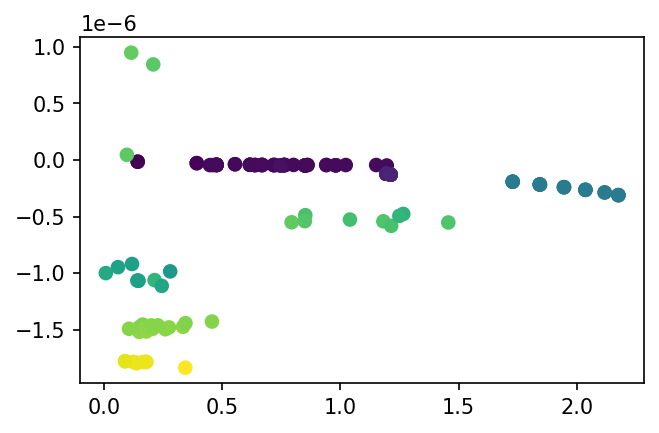

In [45]:
tdbase = 'pitzer_Li'
tSI_calcite = np.concatenate([nom(u_mdf.loc[:, (tdbase, 'si_Calcite')]), lit[(tdbase, 'si_Calcite')]])

odbase = 'pitzer'
oSI_calcite = np.concatenate([nom(u_mdf.loc[:, (odbase, 'si_Calcite')]), lit[(odbase, 'si_Calcite')]])

cLi = np.concatenate([nom(u_mdf.loc[:, (odbase, 'Li(mol/kgw)')]), lit[(odbase, 'Li(mol/kgw)')]])

plt.scatter(oSI_calcite, oSI_calcite - tSI_calcite, c=cLi)



In [46]:
# plt.scatter(SI_calcite, tSI_calcite)

(7.676888910970948e-08+/-7.966460799434984e-09, 1.195154229037868+/-0.03474420848819391)


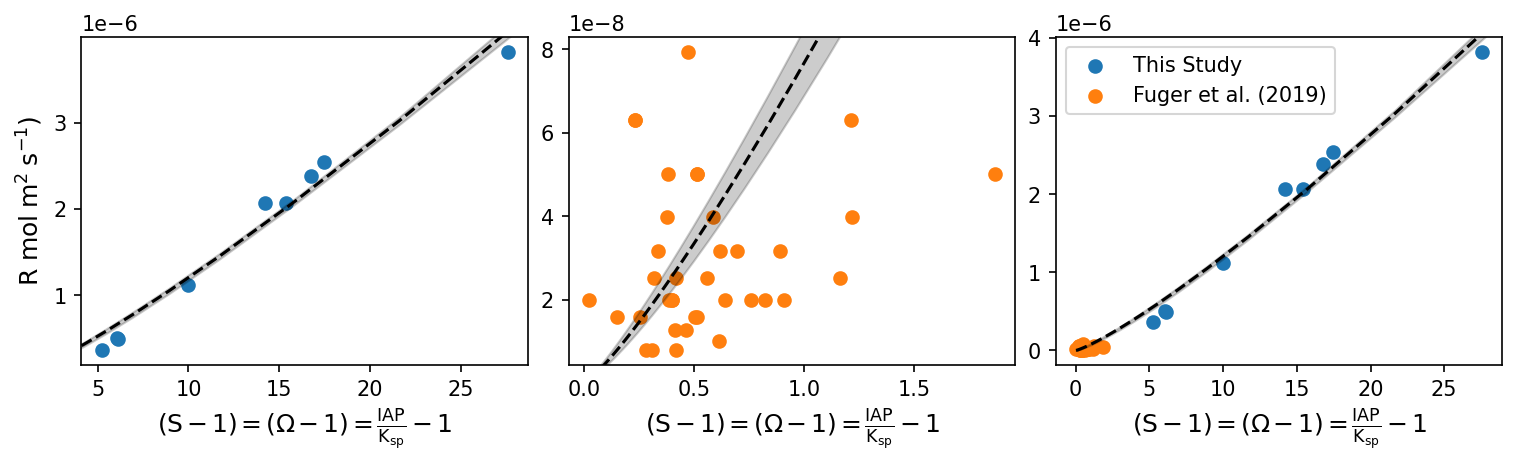

In [48]:
## Calculated log10R from SI_calcite
from scipy.optimize import curve_fit

# plt.scatter(10**(nom(u_mdf.loc[:, (use_dbase, 'si_Calcite')])) - 1, (nom(u_mdf.loc[:, ('R', 'log10R_13C')])), label='This Study')

# plt.scatter(10**(lit[(use_dbase, 'si_Calcite')]) - 1, (lit[('solid', 'logR')]), marker='s', label='Fuger et al. (2019)')

# plt.legend()

SI_calcite = np.concatenate([nom(u_mdf.loc[:, (use_dbase, 'si_Calcite')]), lit[(use_dbase, 'si_Calcite')]])
log10R = np.concatenate([(nom(u_mdf.loc[:, ('R', 'log10R_13C')])), (lit[('solid', 'logR')])])
ind = np.isnan(SI_calcite) | np.isnan(log10R)

S = 10**SI_calcite
R = 10**log10R

lnS = np.log(S)
lnR = np.log(R)

def Rfn(SI, k, n):
    """R as a function of SI"""
    return k * (10**SI - 1)**n

p, cov = curve_fit(Rfn, SI_calcite[~ind], R[~ind], p0=[0, 1])
up = un.correlated_values(p, cov)

nx = np.logspace(-2, np.log10(1.5))
pred = Rfn(nx, *up)

print(up)

log10R = unp.log10(Rfn(lit[(use_dbase, 'si_Calcite')], *up))

lit[('solid', 'calc_logR')] = nom(log10R)
lit[('solid', 'calc_logR_2std')] = err(log10R) * 2


fig, axs = plt.subplots(1, 3, figsize=[10, 3], constrained_layout=True)

ax = axs[-1]

pt_ts = ax.scatter(S[:u_mdf.shape[0]] - 1, R[:u_mdf.shape[0]], label='This Study')
pt_fg = ax.scatter(S[u_mdf.shape[0]:] - 1, R[u_mdf.shape[0]:], label='Fuger et al. (2019)')
ax.legend()

axs[0].scatter(S[:u_mdf.shape[0]] - 1, R[:u_mdf.shape[0]], color=pt_ts.get_facecolor())
axs[1].scatter(S[u_mdf.shape[0]:] - 1, R[u_mdf.shape[0]:], color=pt_fg.get_facecolor())

for ax in axs:
    ax.set_xlabel(r'$(S - 1) = (\Omega - 1) = \frac{IAP}{K_{sp}} - 1$')
    xlim = ax.get_xlim()
    ax.set_xlim(xlim)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim)
    ax.plot(10**nx - 1, nom(pred), 'k--')
    ax.fill_between(10**nx - 1, nom(pred) - err(pred), nom(pred) + err(pred), color='k', alpha=0.2)
    
axs[0].set_ylabel('R $mol~m^2~s^{-1}$)')

savefig(plt.gcf(), 'S1_log10R_vs_SI_Calcite')

In [49]:
lit.to_pickle('data/processed_LiDataLiterature.pkl')